In [6]:
# import functions
import sys
import os
from pathlib import Path
import pandas as pd
import re
import numpy as np  
import submitit
import os 
import mne
from extraction_data import get_pid_eid_pairs, get_epoch_StimOn
from Time_frequency_selectives import  load_decoding_results, selective_channels 


# get the pid and eid of the sessions to analyze
regionOfInterest = ['VISp'] # regions to include
pid_eid_pairs = get_pid_eid_pairs( regions = regionOfInterest,only_passive= True)

# get the decoding results
decoding_results_dir = os.path.join(str(Path(os.getcwd()).resolve().parent.parent), 'Decoding_spikes', 'results')
results = load_decoding_results(pid_eid_pairs, suffix = 'v1_TPassive_TActive' , dir = decoding_results_dir)
right_selective, left_selective, right_sensitive, left_sensitive, neutral = selective_channels(results,p_value_threshold = 0.05, accuracy_threshold = 0.57 )
print('###############################################')
RS_ch = right_selective['acronyms']
LS_ch = left_selective['acronyms']

# print the number of selective channels per region
data = []
for region in regionOfInterest:
    RS_count = len([ch for ch in RS_ch if re.match(rf'^{region}[12456]', ch)])
    LS_count = len([ch for ch in LS_ch if re.match(rf'^{region}[12456]', ch)])
    data.append([region, RS_count, LS_count])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Region', 'Right Selective', 'Left Selective'])
print(df)
print('###############################################')
right_selective_pids = []
left_selective_pids = []
right_selective_channels = []
left_selective_channels = []
for pid, eid in pid_eid_pairs:
    ch_index_right = right_selective.loc[right_selective['pid'] == pid, 'ch_indexs'].tolist()
    ch_index_left = left_selective.loc[left_selective['pid'] == pid, 'ch_indexs'].tolist()

    if len(ch_index_right)> 0:
        right_selective_pids.append(pid)
        right_selective_channels.append(ch_index_right)
    if len(ch_index_left) > 0:
        left_selective_pids.append(pid)
print('Right selective pids: ', right_selective_pids)
print('Left selective pids: ', left_selective_pids)

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Total number of possible probe insertions: 73
Number of sessions without passive data: 23
Number of sessions with passive data: 50
Number of pids without decoding result: 6
 number of total channnels 1228
###############################################
  Region  Right Selective  Left Selective
0   VISp               18              21
###############################################
Right selective pids:  ['b114e7e0-92b3-43bb-9529-53860e52606d', '799d899d-c398-4e81-abaf-1ef4b02d5475', '12c0f3a9-518e-4dac-9651-5d95c2b4730f', '27bac116-ea57-4512-ad35-714a62d259cd', 'b83407f8-8220-46f9-9b90-a4c9f150c572', '1f555fc6-5067-428b-a284-da6fb0b6b3a0', 'b78b3c42-eee5-47c6-9717-743b78c0b721', '4b93a168-0f3b-4124-88fa-a57046ca70e1', '578ca001-8cf5-4d30-b58f-1d574eaf808a', 'fb0de39b-c750-4adc-af18-12bf8a22ed41', 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 'df07180e-268e-489c-826e-40cb6f63d3a5', 'b40d8c65-7ee8-4069-8b64-1a3f7907

# V1

# 1) TFR left 80  - left 20 blocks during anticiaption of the target in left selective electrodes

In [3]:
from Time_frequency_selectives import compute_TFR
import submitit
import pickle

def TF_in_one_big_job(pids, selectives, c1_preprocessing, c2_preprocessing, freqs, TF_parameters, version, file_name, accurecy_side = 'Left'):
    acc_column = 'accuracies_c2' if accurecy_side == 'Left' else accurecy_side == 'accuracies_c1'
    pval_column = 'p_value_c2' if accurecy_side == 'Left' else accurecy_side == 'p_value_c1'
    results = []
    for i, pid in enumerate(pids):
        # if i>0 :
        #     break
        print(f'Processing pid {pid} ({i + 1}/{len(pids)})')
        diff,  n_trials_c1, n_trials_c2, ch_index, acronym,  frequencies, times = compute_TFR(pid, selectives, c1_preprocessing, c2_preprocessing, freqs, TF_parameters, version = version)
        for i, ch in enumerate(ch_index):

            accuracy = selectives.loc[(selectives['pid'] == pid) & (selectives['ch_indexs'] == ch), acc_column].values[0]   
            pValue = selectives.loc[(selectives['pid'] == pid) & (selectives['ch_indexs'] == ch), 'p_values'].values[0]     

            data= {'TF': diff[i, : , :] ,'pid': pid, 'n_trials_c1': n_trials_c1, 'n_trials_c2': n_trials_c2, 'ch_index': ch, 'acronym': acronym[i],
                   'accurecy': accuracy, 'pvalue': pValue, 'freqs': frequencies, 'times': times}
            
            results.append(data)
    # save the results
    results_dir = os.path.join(str(Path(os.getcwd()).resolve().parent), 'TF_data')
    os.makedirs(results_dir, exist_ok = True)
    file_name = os.path.join(results_dir, file_name)
    with open(file_name, 'wb') as f:
        pickle.dump(results, f)


cpus = os.cpu_count()
BiasLeft_preprocessing = { 'tmin': -1, 'tmax': 0, 'contrasts': 'all', 'stim_side': "both", 'prob_left': [0.8], 'remove_first_trials_of_block': True, 'save': False}
BiasRight_preprocessing = { 'tmin': -1, 'tmax': 0, 'contrasts': 'all', 'stim_side': "both", 'prob_left': [0.2], 'remove_first_trials_of_block': True, 'save': False}

freqs = np.arange(1, 50, 1)
TF_parameters = {'n_cycles': freqs/5, 'time_bandwidth': 4.0, 'n_jobs': cpus}
version = 'bipolar'
file_name = f'BiasLeft_BiasRight_antic_{version}.pkl'

executor = submitit.AutoExecutor(folder="logs")
# set timeout in min, and partition for running the job
executor.update_parameters(timeout_min= 480, slurm_partition="dev", cpus_per_task = cpus, mem_gb= cpus*4 - 1.5) 
job_1 = executor.submit(TF_in_one_big_job, left_selective_pids, left_selective, BiasLeft_preprocessing, BiasRight_preprocessing, freqs, TF_parameters, version, file_name, accurecy_side = 'Left')





In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
def load_tf_data(file_path):
    """
    Load TF data from a pickle file.

    Parameters
    ----------
    file_path : str
        Full path to the pickle file.

    Returns
    -------
    data : list of dict
        List of dictionaries containing the TF data and associated info.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [ ]:
import os

path = os.path.expanduser(r'C:\Users\gmoha\Downloads\git\ibl-oscillations\_analyses\Time_frequency_selectives\TF_data\BiasLeft_BiasRight_antic_bipolar.pkl')
TF_data = load_tf_data(path)




# 2) TFR right 80 - right 20 blocks during anticiaption of the target in right selective electrodes

total right selective electrodes for condition BiasRight_BiasLeft_anticip is 13
Processing region: VISp


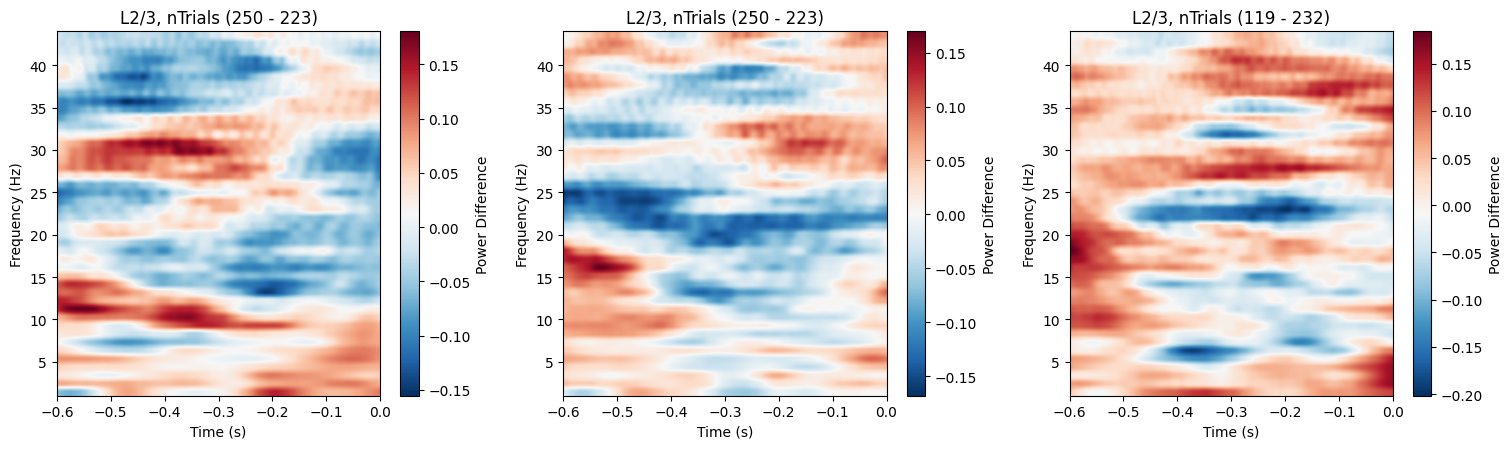

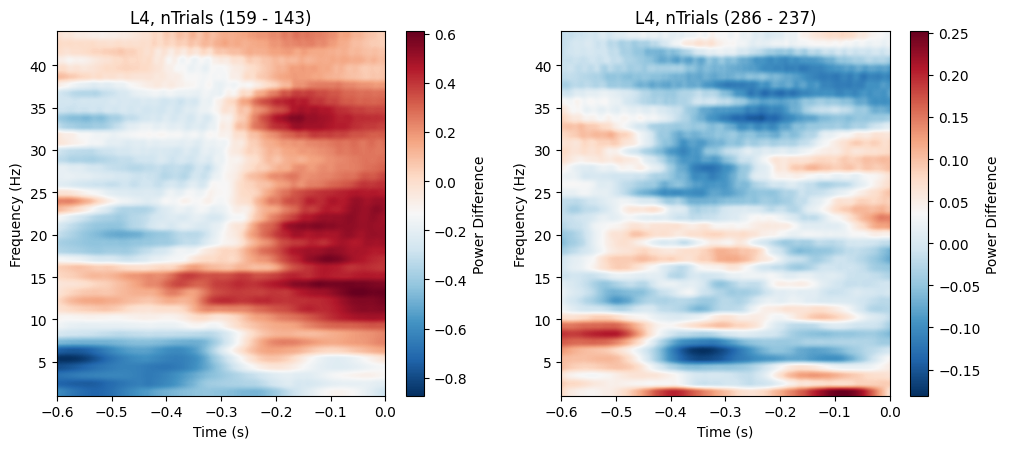

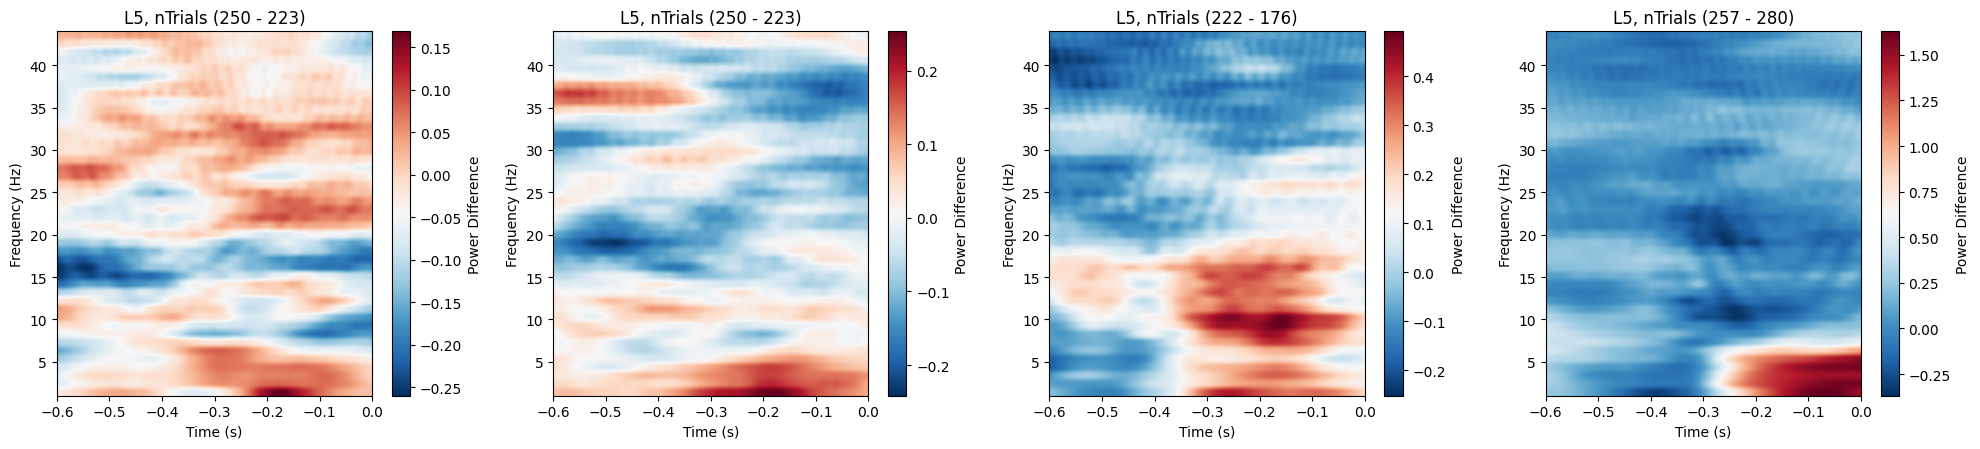

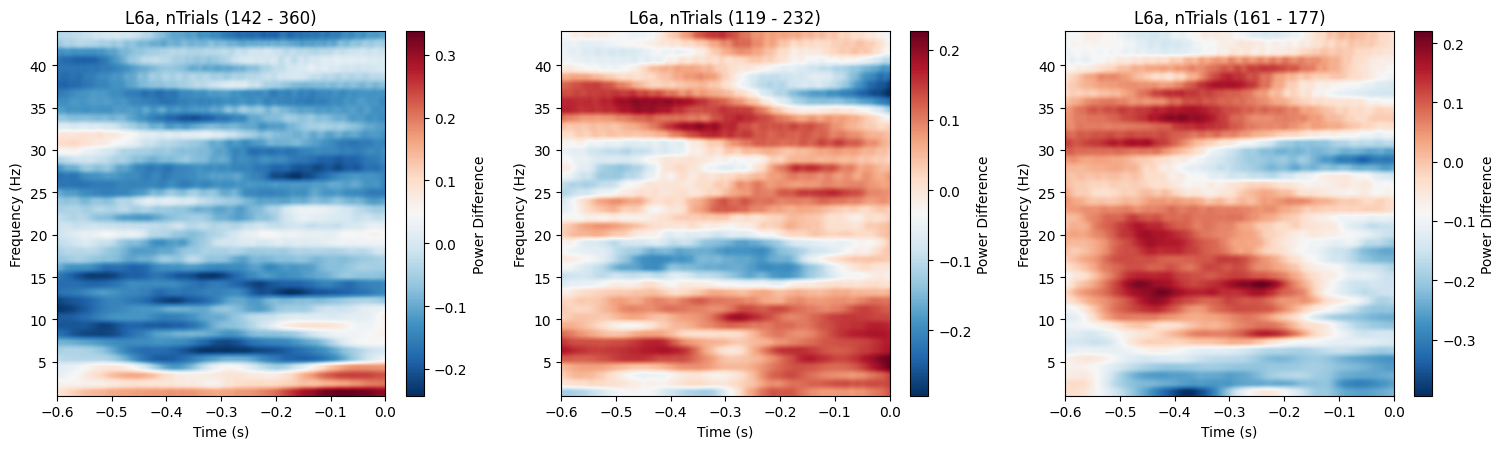

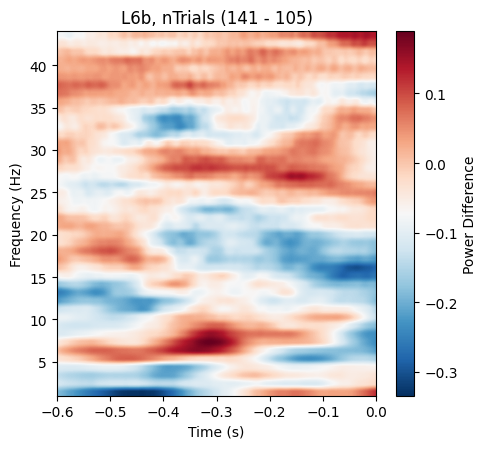

In [4]:
side_selective = 'right'
order = 'Right-Left'
condition = 'BiasRight_BiasLeft_anticip' 
tmin = -0.6
tmax = 0
selectives = pd.concat([right_selective, left_selective])
selectives = selectives[~selectives['ch_indexs'].isin([0, 383])]
pids = np.unique(selectives['pid'].values)
visual_areas = ['VISp', 'VISpm', 'VISam', 'VISa', 'VISrl', 'VISal', 'VISli', 'VISl']
visual_areas = ['VISp']


# in left selective electrodes
#- TFR for left  vs right  during anticiaption of the target in left selective electrodes
BR_TF_all, BL_TF_all, ch_names, times, freqs, BR_n_trials , BL_n_trials = aggregate_TFs(pids, selectives, condition , side_selective  , visual_areas, tmin,  tmax)
diff  = BR_TF_all - BL_TF_all
print(f"total {side_selective} selective electrodes for condition {condition} is {len(ch_names)}")
plot_time_frequency_diff( diff, times, freqs, ch_names, BL_n_trials, BR_n_trials, side_selective , visual_areas, order)
